In [1]:
# Import libraries
from keras import backend  # required for loading model
# from keras.saving import load_model # replace next line with this if you get an import load_model error.
from keras.models import load_model
import dask.array as da
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pickle
from sklearn import svm

import dask
dask.config.set(scheduler='synchronous') # to avoid memory issues

2024-04-10 17:45:06.770759: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-10 17:45:06.798510: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Classification

### Steps:
1. load data: 1) test sample; 2) class examples
1. load the trained Siamese model
1. pair the test sample with all class examples
1. compute similarity scores using Siamese model
1. perform classification based on the similarity scores:
    - average similarity score
    - K-nearest neighbors
    - Support Vector Machine (SVM)

### Load test sample

In [2]:
# test_sample = xr.open_zarr('data/test_sample_reforestree.zarr/')
test_sample = xr.open_zarr('data/test_example_brazil.zarr/')
test_sample

<xarray.Dataset>
Dimensions:  (x: 400, y: 400, channel: 3)
Dimensions without coordinates: x, y, channel
Data variables:
    X        (x, y, channel) float32 dask.array<chunksize=(400, 400, 3), meta=np.ndarray>

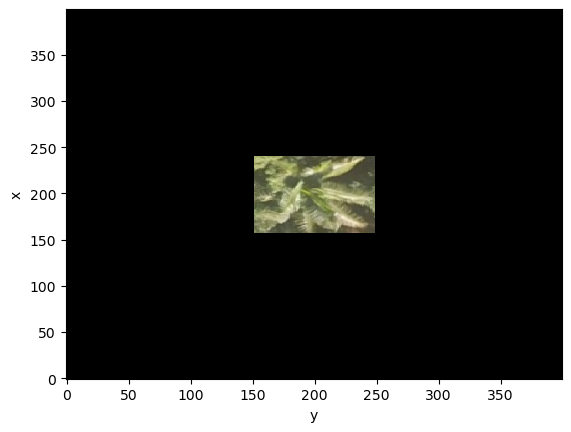

In [3]:
# Visualize the test sample
test_sample['X'].astype('int').plot.imshow()

### Load example classes

In [4]:
class_files = sorted([file for file in Path('data/example_classes/').rglob('*.zarr')])
class_files

[PosixPath('data/example_classes/class_banana.zarr'),
 PosixPath('data/example_classes/class_cacao.zarr'),
 PosixPath('data/example_classes/class_fruit.zarr'),
 PosixPath('data/example_classes/class_palmtree.zarr')]

In [5]:
# Manually create a map between class text and integer label
class_map = {0: 'banana', 1:'cacao', 2:'fruit', 3:'palmtree'}

class_data={}
for class_i in range(len(class_files)):
    class_data[class_i] = xr.open_zarr(class_files[class_i])
class_data

{0: <xarray.Dataset>
 Dimensions:  (sample: 432, x: 400, y: 400, channel: 3)
 Dimensions without coordinates: sample, x, y, channel
 Data variables:
     X        (sample, x, y, channel) float32 dask.array<chunksize=(1, 400, 400, 3), meta=np.ndarray>
 Attributes:
     description:  banana
     source:       https://github.com/gyrrei/ReforesTree,
 1: <xarray.Dataset>
 Dimensions:  (sample: 432, x: 400, y: 400, channel: 3)
 Dimensions without coordinates: sample, x, y, channel
 Data variables:
     X        (sample, x, y, channel) float32 dask.array<chunksize=(1, 400, 400, 3), meta=np.ndarray>
 Attributes:
     description:  cacao
     source:       https://github.com/gyrrei/ReforesTree,
 2: <xarray.Dataset>
 Dimensions:  (sample: 432, x: 400, y: 400, channel: 3)
 Dimensions without coordinates: sample, x, y, channel
 Data variables:
     X        (sample, x, y, channel) float32 dask.array<chunksize=(1, 400, 400, 3), meta=np.ndarray>
 Attributes:
     description:  fruit
     source:    

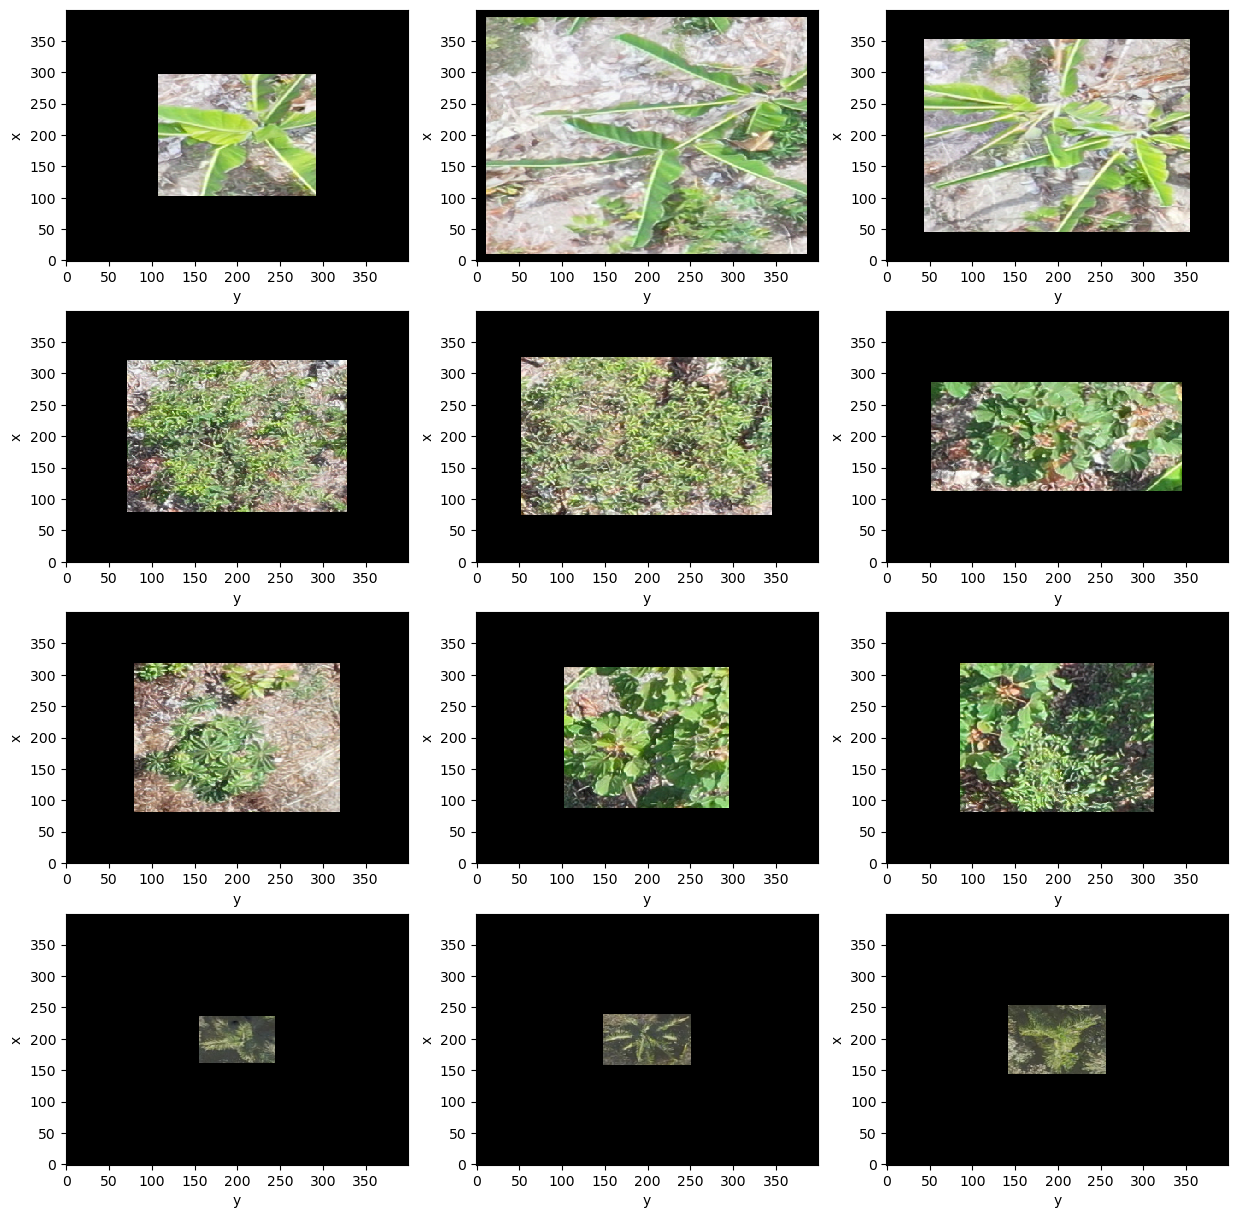

In [6]:
# Visualize first three examples in each example class
fig, axs = plt.subplots(4, 3, figsize=(15, 15))
for class_i in range(len(class_data)):
    for example_i in range(3):
        class_data[class_i]['X'][example_i].astype('int').plot.imshow(ax=axs[class_i, example_i])

### load the trained Siamese model

In [7]:
siamese_model = load_model('../optimized_models/siamese_model.h5')
siamese_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 128)                  393856    ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 128)                  0         ['model[0][0]',         

In [8]:
# Due to memory limit, we make a function to compute the similarity score per batch
batch_size = 10  # number of samples to process at once to compute similarity score
def predict_per_chunk(x, y):
    """Compute similarity score between two sets of images in the same bacth."""
    return siamese_model.predict([x, y], verbose=0).squeeze()

# Compute similarity scores between the test sample and each example class
similarity_scores = {}
list_scores = []
for class_i in class_map.keys():
    
    # Make sample and example class data pairs
    shape = class_data[class_i]["sample"].shape[0]
    X_sample_norm = test_sample.expand_dims({"sample": shape})["X"] / 255.0
    X_class_norm = class_data[class_i]["X"] / 255.0

    # Chunk the data
    X_sample_norm = X_sample_norm.chunk({"sample": batch_size})
    X_class_norm = X_class_norm.chunk({"sample": batch_size})

    # Compute similarity scores per batch
    scores = da.map_blocks(
        predict_per_chunk,
        X_sample_norm.data,
        X_class_norm.data,
        dtype="float32",
        chunks=(batch_size,),
        drop_axis=(1, 2, 3),
    )
    scores = scores.compute()

    similarity_scores[class_i] = scores

In [9]:
similarity_scores

{0: array([3.59668359e-02, 9.02648747e-01, 4.02319223e-01, 8.88849258e-01,
        8.95611644e-01, 1.36072212e-03, 9.40467179e-01, 7.85852611e-01,
        9.90465760e-01, 9.74412739e-01, 9.78032649e-01, 9.19051945e-01,
        1.19018376e-01, 9.83240068e-01, 9.42239106e-01, 6.62206173e-01,
        9.95077908e-01, 9.58876312e-01, 9.34606731e-01, 4.95481312e-01,
        8.81240845e-01, 5.45549512e-01, 8.85399342e-01, 9.96990561e-01,
        8.90858173e-01, 9.11172748e-01, 8.23289454e-01, 9.15236115e-01,
        9.48607087e-01, 3.19275320e-01, 9.86297548e-01, 9.15614963e-01,
        9.13956240e-02, 5.97991887e-03, 6.11339509e-01, 3.94387022e-02,
        9.78940308e-01, 8.62178743e-01, 3.95099133e-01, 9.86866593e-01,
        9.89779532e-01, 2.55432054e-02, 5.32213151e-01, 2.56425142e-01,
        8.98141682e-01, 3.77705365e-01, 7.64148414e-01, 9.27810848e-01,
        9.05472517e-01, 3.52712125e-01, 8.27024341e-01, 9.76525366e-01,
        1.48533601e-02, 9.21472490e-01, 4.00955796e-01, 5.773

In [10]:
# Save the similarity scores to piclke file
with open('data/similarity_scores.pkl', 'wb') as f:
    pickle.dump(similarity_scores, f)

## Classification

In [11]:
# Load the similarity scores from pickle file
with open('data/similarity_scores.pkl', 'rb') as f:
    similarity_scores = pickle.load(f)
similarity_scores

{0: array([3.59668359e-02, 9.02648747e-01, 4.02319223e-01, 8.88849258e-01,
        8.95611644e-01, 1.36072212e-03, 9.40467179e-01, 7.85852611e-01,
        9.90465760e-01, 9.74412739e-01, 9.78032649e-01, 9.19051945e-01,
        1.19018376e-01, 9.83240068e-01, 9.42239106e-01, 6.62206173e-01,
        9.95077908e-01, 9.58876312e-01, 9.34606731e-01, 4.95481312e-01,
        8.81240845e-01, 5.45549512e-01, 8.85399342e-01, 9.96990561e-01,
        8.90858173e-01, 9.11172748e-01, 8.23289454e-01, 9.15236115e-01,
        9.48607087e-01, 3.19275320e-01, 9.86297548e-01, 9.15614963e-01,
        9.13956240e-02, 5.97991887e-03, 6.11339509e-01, 3.94387022e-02,
        9.78940308e-01, 8.62178743e-01, 3.95099133e-01, 9.86866593e-01,
        9.89779532e-01, 2.55432054e-02, 5.32213151e-01, 2.56425142e-01,
        8.98141682e-01, 3.77705365e-01, 7.64148414e-01, 9.27810848e-01,
        9.05472517e-01, 3.52712125e-01, 8.27024341e-01, 9.76525366e-01,
        1.48533601e-02, 9.21472490e-01, 4.00955796e-01, 5.773

### Method 1: Average similarity score

In [12]:
# Compute the average similarity score per example class
average_scores = {}
for class_i in similarity_scores.keys():
    average_scores[class_i] = np.mean(similarity_scores[class_i])
average_scores

{0: 0.6481197, 1: 0.6887809, 2: 0.67503595, 3: 0.8456451}

In [13]:
predicted_class = class_map[np.argmax(list(average_scores.values()))]
print(f"Prediction by average similarity score: {predicted_class}")

Prediction by average similarity score: palmtree


## Metod 2: K-nearest neighbors

In [14]:
# Manual input: the number of K
k = 3

In [15]:
# Get the top K highest similarity scores and their corresponding class

# first search for the top k scores per class
top_k_scores = {}
for class_i in similarity_scores.keys():
    top_k_scores[class_i] = np.sort(similarity_scores[class_i])[-k:]

# Reverse the dictionary
reversed_dict = {vi: k for k, v in top_k_scores.items() for vi in v}

# then sort the top k scores from all classes and 
top_k_scores_all = np.concatenate(list(top_k_scores.values()))
top_k_scores_all_sorted = np.sort(top_k_scores_all)[::-1][0:k]

# find the class with most top k scores
top_k_classes = [reversed_dict[key] for key in top_k_scores_all_sorted]
counter = Counter(top_k_classes)
most_common_value = counter.most_common(1)[0][0]

print(f"Prediction by KNN: {class_map[most_common_value]}")

Prediction by KNN: cacao


## Method 3: Support Vector Machine (SVM)

In [16]:
# Import the trained SVM and perform prediction based on statistis of similarity scores
# Load the trained SVM model from pickle file
with open('../optimized_models/svm_classifier.pkl', 'rb') as f:
    svm_model = pickle.load(f)
svm_model

SVC()

In [18]:
# This prediction takes mean similarity scores of each class as input
mean_scores = np.array([average_scores[class_i] for class_i in range(len(class_map))]).reshape(1, -1)
mean_scores

array([[0.6481197 , 0.6887809 , 0.67503595, 0.8456451 ]], dtype=float32)

In [23]:
# Make prediction
prediction = svm_model.predict(mean_scores)[0].astype(int)
print(f"Prediction by SVM: {class_map[prediction]}")


Prediction by SVM: cacao
